In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# shorthand
noise = lambda size, loc=0., scale=1.: np.random.normal(loc=loc, scale=scale, size=size)
reg = LinearRegression()

# Structural causal models (SCMs)

- Consider a "system of assignments" consisting of $M$ variables $X_1,\ldots,X_M$ and $M$ noise terms $U_1,\ldots,U_M$
- Represent the system by a directed acyclic graph $\mathcal{G}=(\mathcal{V},\mathcal{E})$, where $\mathcal{V}=\{1,\ldots,M\}$ denote the vertices (variable indices) and $\mathcal{E}\subset\mathcal{V}\times\mathcal{V}$ denote the edges
- $(m,n)\in\mathcal{E}$ indicates a directed edge $m\to n$
- We assume the following generative model for each unit $\omega$ in the population of interest $\Omega$:
$$
\begin{aligned}
U_m^{(\omega)} &:= u_m^{(\omega)}\sim P(U_m) \\
X_m^{(\omega)} &:= F_m(\textbf{PA}_m^{(\omega)},U_m^{(\omega)}) \qquad\text{for }m=1,\ldots,M,\\
\end{aligned}
$$
where $\textbf{PA}_m=\{n: (n,m)\in\mathcal{E}\}$ are $m$'s parents in $\mathcal{G}$
- $\{F_1,\ldots,F_M\}$ are assumed to be deterministic functions; $P(U_1,\ldots,U_M)=\prod_m P(U_m)$ induces a distribution over $P(X_1,\ldots,X_M)$.
- Let $\tilde{X}_m^{(\omega)}$ be the outcome of the system above under some _intervention_ -- defined as a reassignment of some set of nodes $\tilde{\mathcal{V}}_U,\tilde{\mathcal{V}}_X\subset\mathcal{V}$ where $U^{(\omega)}_n:=u_n$ for $n\in\tilde{\mathcal{V}}_U$ and $X^{(\omega)}_n:=x_n$ for $n\in\tilde{\mathcal{V}}_X$.
- $\tilde{X}_m^{(\omega)}\equiv X^{(\omega)}_m\,|\,[U^{(\omega)}_n:=u_n]_{\tilde{\mathcal{V}}_U}\cup[X^{(\omega)}_n:=x_n]_{\tilde{\mathcal{V}}_X}$
- Holy grail: compute $P(\tilde{X}_m^{(\omega)})$. If we can do this, we can answer all sorts of counterfactual queries:
  - $P(\tilde{X}^{(\omega)}_m-X^{(\omega)}_m|X^{(\omega)}_m)$
  - $\mathbb{E}_{\tilde{X}_m^{(\omega)}\sim P(\tilde{X}_m^{(\omega)})}[\tilde{X}^{(\omega)}_m]-X^{(\omega)}_m$
  - $\mathbb{E}_{\omega\sim P(\Omega)}\left[\mathbb{E}_{\tilde{X}_m^{(\omega)}\sim P(\tilde{X}_m^{(\omega)})}\left[\tilde{X}^{(\omega)}_m\right]-X^{(\omega)}_m\right]$
  - $\mathbb{E}_{\omega\sim P(\Omega)}\left[\mathbb{E}_{\tilde{X}_m^{(\omega)}\sim P(\tilde{X}_m^{(\omega)})}\left[\tilde{X}^{(\omega)}_m\right]-\mathbb{E}_{\hat{X}_m^{(\omega)}\sim P(\hat{X}_m^{(\omega)})}\left[\hat{X}^{(\omega)}_m\right]\right]$
  - $\mathbb{E}_{\omega\sim P(\Omega|\underline{x}_n\le X_n^{(\omega)}\le\overline{x}_n)}\left[\mathbb{E}_{\tilde{X}_m^{(\omega)}\sim P(\tilde{X}_m^{(\omega)})}\left[\tilde{X}^{(\omega)}_m\right]-\mathbb{E}_{\hat{X}_m^{(\omega)}\sim P(\hat{X}_m^{(\omega)})}\left[\hat{X}^{(\omega)}_m\right]\right]$

# Example of a collider

Let's illustrate an example where two variables $W$ and $X$ are unconditionally independent but become dependent after conditioning on $Y$.

<img src="graph_0.png" width="300">

Suppose that admission to a particular college depends on grades, measured by a continuous variable $W\sim\text{Normal}(0,1)$, and community service, measured by a continuous variable $X\sim\text{Normal}(0,1)$. Importantly, we assume that $W$ and $X$ are generated iid. Universities score applicants by summing their grades and community service activities, $Y=W+X$, and accept only the top 25% of such applicants.

We simulate this example below. Note that, in the general population, grades and community service are independent. However, when we look at the subpopulation of accepted students, grades and community service are in fact dependent (and exhibit negative correlation).

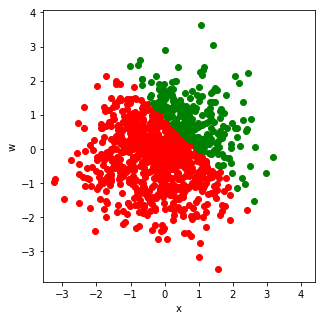

Correlation in general population: 0.0316.
Correlation in accepted sub-population: -0.5502.


In [2]:
w = noise([1000])
x = noise([1000])
y = w + x
y = (y >= np.percentile(y, 75))

plt.figure(figsize=(5, 5))
plt.scatter(x[~y], w[~y], color='red')
plt.scatter(x[y], w[y], color='green')
plt.xlabel('x')
plt.ylabel('w')
plt.axis('square')
plt.show()

print('Correlation in general population: {0:.4f}.'.format(np.corrcoef(x, w)[0, 1]))
print('Correlation in accepted sub-population: {0:.4f}.'.format(np.corrcoef(x[y], w[y])[0, 1]))

# Numerical examples

Let's try to apply what we discussed. To keep things simple, we will use a linear Gaussian structural causal models (SCMs) in all of the examples in this notebook.

## Causal effect identification using the back-door criterion

Consider a structural causal model (SCM) satisfying the conditional independence assumptions encoded in the graph $\mathcal{G}$ below:

<img src="graph_1.png" width="400">

The generative model is given by:

$$
\begin{aligned}
U &\sim \text{Normal}(0, 1^2) \\
V &\sim \text{Normal}(0, 1^2) \\
W &\sim \text{Normal}(3\cdot V, 2.5^2) \\
X &\sim \text{Normal}(6\cdot U + 4.5\cdot V, 2^2) \\
Z &\sim \text{Normal}(2.5\cdot W, 3^2) \\
Y &\sim \text{Normal}(3.2\cdot U + 4\cdot W + 5.3\cdot X + 1.6\cdot Z, 1.5^2) \\
\end{aligned}
$$

#### Total causal effect of $W$ on $Y$

A $1$ unit increase in $W$ induces an increase of $4 + 1.6\times 2.5 = 8$ units in $Y$.

We deduced that conditioning on any of $\{V\}$, $\{U, V\}$, $\{U, X\}$, $\{V, X\}$, or $\{U, V, X\}$ is sufficient for identification of the causal effect of interest.

#### Partial causal effect of $W$ on $Y$ through the path $W\to Y$

A $1$ unit increase in $W$ induces an increase of $4$ units in $Y$ through the path $W\to Y$

We deduced that conditioning on any of $\{V, Z\}$, $\{U, V, Z\}$, $\{U, X, Z\}$, $\{V, X, Z\}$, or $\{U, V, X, Z\}$ is sufficient for identification of the causal effect of interest.

#### Total causal effect of $X$ on $Y$

A $1$ unit increase in $X$ induces an increase of $5.3$ units in $Y$.

We deduced that conditioning on any of $\{U, V\}$, $\{U, W\}$, $\{U, V, W\}$, $\{U, V, Z\}$, $\{U, W, Z\}$, or $\{U, V, W, Z\}$ is sufficient for identification of the causal effect of interest.

### Let's try to estimate these causal effects from some simulated data

In [3]:
# We'll use 500k samples in each of our examples so that we can see what happens in the large sample limit
nb_obs = 500000

In [4]:
# Generate some data
u = noise([nb_obs, 1])
v = noise([nb_obs, 1])
w = 3.0 * v + 2.5 * noise([nb_obs, 1])
x = 6.0 * u + 4.5 * v + 2.0 * noise([nb_obs, 1])
z = 2.5 * w + 3.0 * noise([nb_obs, 1])
y = 3.2 * u + 4.0 * w + 5.3 * x + 1.6 * z + 1.5 * noise([nb_obs, 1])

In [5]:
print("Query: Total causal effect of W on Y. (Ground truth: 8.0)\n")

print(">> Examples of unconfounded identification <<")

# Condition on {V}
effect = reg.fit(np.hstack([w, v]), y).coef_[0][0]
print("Estimated total causal effect of W on Y when conditioning on {{V}}: {0:.4f}".format(effect))

# Condition on {U, V}
effect = reg.fit(np.hstack([w, u, v]), y).coef_[0][0]
print("Estimated total causal effect of W on Y when conditioning on {{U, V}}: {0:.4f}".format(effect))

# Condition on {U, X}
effect = reg.fit(np.hstack([w, u, x]), y).coef_[0][0]
print("Estimated total causal effect of W on Y when conditioning on {{U, X}}: {0:.4f}".format(effect))

# Condition on {V, X}
effect = reg.fit(np.hstack([w, v, x]), y).coef_[0][0]
print("Estimated total causal effect of W on Y when conditioning on {{V, X}}: {0:.4f}".format(effect))

# Condition on {U, V, X}
effect = reg.fit(np.hstack([w, u, v, x]), y).coef_[0][0]
print("Estimated total causal effect of W on Y when conditioning on {{U, V, X}}: {0:.4f}".format(effect))

print("\n>> Examples of confounded identification <<")

# Condition on {U}
effect = reg.fit(np.hstack([w, u]), y).coef_[0][0]
print("Estimated total causal effect of W on Y when conditioning on {{U}}: {0:.4f}".format(effect))

# Condition on {X}
effect = reg.fit(np.hstack([w, x]), y).coef_[0][0]
print("Estimated total causal effect of W on Y when conditioning on {{X}}: {0:.4f}".format(effect))

print('\n----------\n')

print("Query: Partial causal effect of W on Y. (Ground truth: 4.0)\n")

print(">> Examples of unconfounded identification <<")

# Condition on {V}
effect = reg.fit(np.hstack([w, v, z]), y).coef_[0][0]
print("Estimated partial causal effect of W on Y when conditioning on {{V, Z}}: {0:.4f}".format(effect))

# Condition on {U, V, Z}
effect = reg.fit(np.hstack([w, u, v, z]), y).coef_[0][0]
print("Estimated partial causal effect of W on Y when conditioning on {{U, V, Z}}: {0:.4f}".format(effect))

# Condition on {U, X, Z}
effect = reg.fit(np.hstack([w, u, x, z]), y).coef_[0][0]
print("Estimated partial causal effect of W on Y when conditioning on {{U, X, Z}}: {0:.4f}".format(effect))

# Condition on {V, X, Z}
effect = reg.fit(np.hstack([w, v, x, z]), y).coef_[0][0]
print("Estimated partial causal effect of W on Y when conditioning on {{V, X, Z}}: {0:.4f}".format(effect))

# Condition on {U, V, X, Z}
effect = reg.fit(np.hstack([w, u, v, x, z]), y).coef_[0][0]
print("Estimated partial causal effect of W on Y when conditioning on {{U, V, X, Z}}: {0:.4f}".format(effect))

print("\n>> Examples of confounded identification <<")

# Condition on {U, Z}
effect = reg.fit(np.hstack([w, u, z]), y).coef_[0][0]
print("Estimated partial causal effect of W on Y when conditioning on {{U, Z}}: {0:.4f}".format(effect))

# Condition on {X}
effect = reg.fit(np.hstack([w, x, z]), y).coef_[0][0]
print("Estimated partial causal effect of W on Y when conditioning on {{X, Z}}: {0:.4f}".format(effect))

print('\n----------\n')

print("Query: Total causal effect of X on Y. (Ground truth: 5.3)\n")

print(">> Examples of unconfounded identification <<")

# Condition on {U, V}
effect = reg.fit(np.hstack([x, u, v]), y).coef_[0][0]
print("Estimated total causal effect of X on Y when conditioning on {{U, V}}: {0:.4f}".format(effect))

# Condition on {U, W}
effect = reg.fit(np.hstack([x, u, w]), y).coef_[0][0]
print("Estimated total causal effect of X on Y when conditioning on {{U, W}}: {0:.4f}".format(effect))

# Condition on {U, V, W}
effect = reg.fit(np.hstack([x, u, v, w]), y).coef_[0][0]
print("Estimated total causal effect of X on Y when conditioning on {{U, V, W}}: {0:.4f}".format(effect))

# Condition on {U, V, Z}
effect = reg.fit(np.hstack([x, u, v, z]), y).coef_[0][0]
print("Estimated total causal effect of X on Y when conditioning on {{U, V, Z}}: {0:.4f}".format(effect))

# Condition on {U, W, Z}
effect = reg.fit(np.hstack([x, u, w, z]), y).coef_[0][0]
print("Estimated total causal effect of X on Y when conditioning on {{U, W, Z}}: {0:.4f}".format(effect))

# Condition on {U, V, W, Z}
effect = reg.fit(np.hstack([x, u, v, w, z]), y).coef_[0][0]
print("Estimated total causal effect of X on Y when conditioning on {{U, V, W, Z}}: {0:.4f}".format(effect))

print("\n>> Examples of confounded identification <<")

# Condition on {U}
effect = reg.fit(np.hstack([x, u]), y).coef_[0][0]
print("Estimated total causal effect of X on Y when conditioning on {{U}}: {0:.4f}".format(effect))

# Condition on {V}
effect = reg.fit(np.hstack([x, v]), y).coef_[0][0]
print("Estimated total causal effect of X on Y when conditioning on {{V}}: {0:.4f}".format(effect))

# Condition on {W}
effect = reg.fit(np.hstack([x, w]), y).coef_[0][0]
print("Estimated total causal effect of X on Y when conditioning on {{W}}: {0:.4f}".format(effect))

# Condition on {U, Z}
effect = reg.fit(np.hstack([x, u, z]), y).coef_[0][0]
print("Estimated total causal effect of X on Y when conditioning on {{U, Z}}: {0:.4f}".format(effect))

# Condition on {V, W}
effect = reg.fit(np.hstack([x, v, w]), y).coef_[0][0]
print("Estimated total causal effect of X on Y when conditioning on {{V, W}}: {0:.4f}".format(effect))

# Condition on {V, Z}
effect = reg.fit(np.hstack([x, v, z]), y).coef_[0][0]
print("Estimated total causal effect of X on Y when conditioning on {{V, Z}}: {0:.4f}".format(effect))

# Condition on {W, Z}
effect = reg.fit(np.hstack([x, w, z]), y).coef_[0][0]
print("Estimated total causal effect of X on Y when conditioning on {{W, Z}}: {0:.4f}".format(effect))

# Condition on {V, W, Z}
effect = reg.fit(np.hstack([x, v, w, z]), y).coef_[0][0]
print("Estimated total causal effect of X on Y when conditioning on {{V, W, Z}}: {0:.4f}".format(effect))

Query: Total causal effect of W on Y. (Ground truth: 8.0)

>> Examples of unconfounded identification <<
Estimated total causal effect of W on Y when conditioning on {V}: 8.0301
Estimated total causal effect of W on Y when conditioning on {U, V}: 7.9989
Estimated total causal effect of W on Y when conditioning on {U, X}: 8.0023
Estimated total causal effect of W on Y when conditioning on {V, X}: 8.0012
Estimated total causal effect of W on Y when conditioning on {U, V, X}: 8.0007

>> Examples of confounded identification <<
Estimated total causal effect of W on Y when conditioning on {U}: 12.6879
Estimated total causal effect of W on Y when conditioning on {X}: 7.6502

----------

Query: Partial causal effect of W on Y. (Ground truth: 4.0)

>> Examples of unconfounded identification <<
Estimated partial causal effect of W on Y when conditioning on {V, Z}: 4.0893
Estimated partial causal effect of W on Y when conditioning on {U, V, Z}: 4.0189
Estimated partial causal effect of W on Y wh

## Causal effect identification using the front-door criterion

Consider a structural causal model (SCM) satisfying the conditional independence assumptions encoded in the graph $\mathcal{G}$ below:

<img src="graph_2.png" width="300">

The generative model is given by:

$$
\begin{aligned}
E &\sim \text{Normal}(0, 1^2) \\
W &\sim \text{Normal}(-2.5\cdot E, 3^2) \\
Z &\sim \text{Normal}(1.2\cdot W, 1.5^2) \\
Y &\sim \text{Normal}(5\cdot Z + 7.3\cdot E, 2.2^2) 
\end{aligned}
$$

#### Total causal effect of $W$ on $Y$

A $1$ unit increase in $W$ induces an increase of $1.2\times 5 = 6$ units in $Y$.

We showed that we can use the front-door criterion (i.e., application of the back-door criterion twice) to identify the causal effect of interest.

In [6]:
e = noise([nb_obs, 1])
w = -2.5 * e + 3.0 * noise([nb_obs, 1])
z = 1.2 * w + 1.5 * noise([nb_obs, 1])
y = 5.0 * z + 7.3 * e + 2.2 * noise([nb_obs, 1])

In [7]:
print("Query: Total causal effect of W on Y. (Ground truth: 6.0)\n")

print(">> Example of unconfounded identification <<")

# Front-door criterion (W -> Z) -> Y
effect = reg.fit(w, z).coef_[0][0] * reg.fit(np.hstack([z, w]), y).coef_[0][0]
print("Estimated total causal effect of W on Y using the front-door criterion: {0:.4f}".format(effect))

print("\n>> Examples of confounded identification <<")

# Condition on {}
effect = reg.fit(w, y).coef_[0][0]
print("Estimated total causal effect of W on Y when conditioning on {{ }}: {0:.4f}".format(effect))

# Condition on {Z}
effect = reg.fit(np.hstack([w, z]), y).coef_[0][0]
print("Estimated total causal effect of W on Y when conditioning on {{Z}}: {0:.4f}".format(effect))

Query: Total causal effect of W on Y. (Ground truth: 6.0)

>> Example of unconfounded identification <<
Estimated total causal effect of W on Y using the front-door criterion: 6.0010

>> Examples of confounded identification <<
Estimated total causal effect of W on Y when conditioning on { }: 4.8065
Estimated total causal effect of W on Y when conditioning on {Z}: -1.1944


## Causal effect identification with an instrumental variable

Consider a structural causal model (SCM) satisfying the conditional independence assumptions encoded in the graph $\mathcal{G}$ below:

<img src="graph_3.png" width="300">

The generative model is given by:

$$
\begin{aligned}
E &\sim \text{Normal}(0, 1^2) \\
Z &\sim \text{Normal}(0, 1^2) \\
W &\sim \text{Normal}(4.5\cdot E - 3.6\cdot Z, 2.3^2) \\
Y &\sim \text{Normal}(-3\cdot E + 1.5\cdot W, 2^2) 
\end{aligned}
$$

#### Total causal effect of $W$ on $Y$

A $1$ unit increase in $W$ induces an increase of $1.5$ units in $Y$.

We showed that we can use the path $(W\to Z)\to Y$ to identify the causal effect of interest

In [8]:
e = noise([nb_obs, 1])
z = noise([nb_obs, 1])
w = 4.5 * e - 3.6 * z + 2.3 * noise([nb_obs, 1])
y = -3.0 * e + 1.5 * w + 2.0 * noise([nb_obs, 1])

In [9]:
print("Query: Total causal effect of W on Y. (Ground truth: 1.5)\n")

print(">> Example of unconfounded identification <<")

# Condition on {||Z}
effect = reg.fit(reg.fit(z, w).predict(z), y).coef_[0][0]
print("Estimated total causal effect of W on Y using the path (W -> Z) -> Y: {0:.4f}".format(effect))

print("\n>> Examples of confounded identification <<")

# Condition on {}
effect = reg.fit(w, y).coef_[0][0]
print("Estimated total causal effect of W on Y when conditioning on {{ }}: {0:.4f}".format(effect))

# Condition on {Z}
effect = reg.fit(np.hstack([w, z]), y).coef_[0][0]
print("Estimated total causal effect of W on Y when conditioning on {{Z}}: {0:.4f}".format(effect))

Query: Total causal effect of W on Y. (Ground truth: 1.5)

>> Example of unconfounded identification <<
Estimated total causal effect of W on Y using the path (W -> Z) -> Y: 1.4987

>> Examples of confounded identification <<
Estimated total causal effect of W on Y when conditioning on { }: 1.1486
Estimated total causal effect of W on Y when conditioning on {Z}: 0.9711
